In [1]:
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click to toggle on/off the raw code.">
</form>''')

In [34]:
# load the libraries
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to prettify and remove the warnings
# the warnings refer to the noteboook of the user
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql.functions import col, explode
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

spark = (SparkSession
     .builder
     .master('local[*]')
     .getOrCreate())

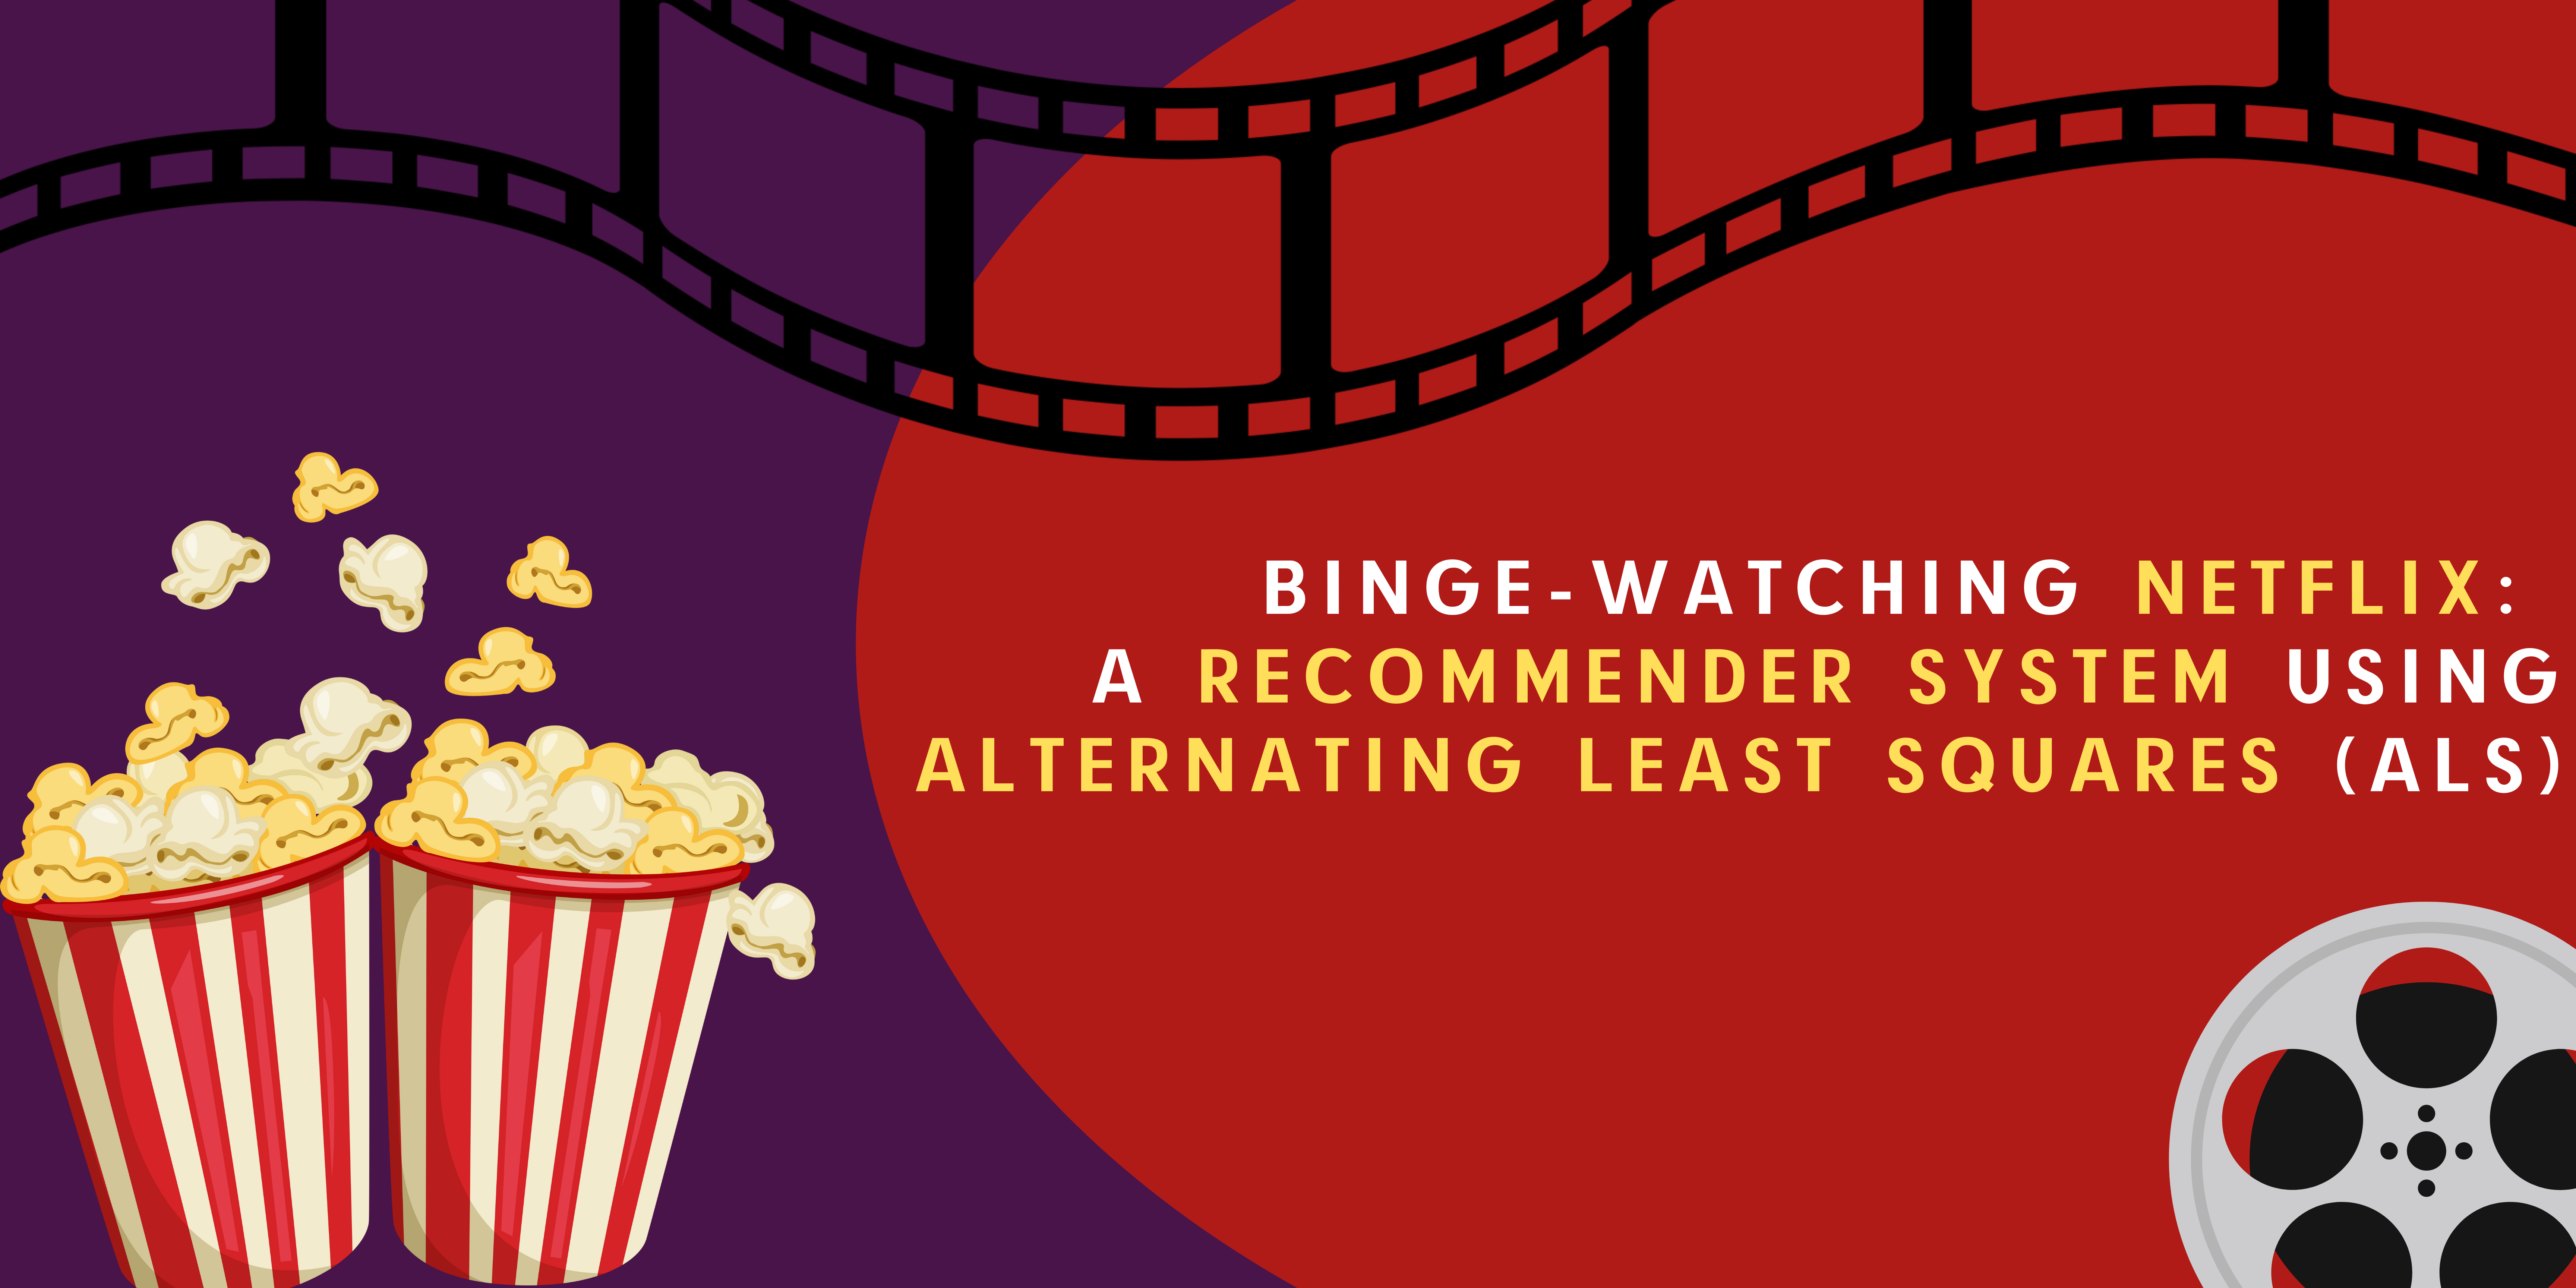

# <span style="background-color: #000000; color: #E50914"> Executive Summary </span>

Personalization is the name of the game. In an era where we are bombarded with so many choices, we want our choices to be curated to limit the guesswork and maximize our entertainment experience. In this study, we applied collaborative filtering using Spark's Machine Learning library `MLlib` on the Netflix dataset. The algorithm used for collaborative filtering was `Alternating Least Squares (ALS)` Matrix Factorization.

The model was run using the traditional machine learning pipeline comprising of separating a train and test set, cross validating the model, performing a grid search of the hyperparameters, evaluating the model using an error metric (RMSE) and inspecting the results. The model resulted to an `RMSE of 0.8766`, compared to the Netflix prize RMSE of 0.8995. These results can be improved if we can utilize the whole dataset. Due to system limitations, only 50% of the dataset was used.

The model was able to recommend movies for an individual user. Since the dataset did not have information on the genre of the movies, we generated it manually based on the title results. Most of the recommended movies corresponded with the user's highly rated genre, which was comedy.

This study was able to demonstrate the viability of performing collaborative filtering using ALS for large datasets. Recommendation for further studies include using the compelete dataset, comparing the performance with other recommender systems, and comparing the result of ALS to SVD using Surprise. 

# <span style="background-color: #000000; color: #E50914"> Introduction </span>

## <span style="color: #E50914;"> Overview </span>


Binge-watching is the habit of watching many movies or television shows in a row. Since 2013, this watching pattern has gained in popularity as a leisure or recreational activity. With the worldwide application of isolation, quarantine, shutdown, and lockdown protocols as a consequence of the COVID-19 outbreak, binge-watching has become one of the most accessible, and sometimes inexpensive, kinds of entertainment for individuals who are confined at home. The streaming business, on the other hand, is spending more in generating web series and movies that lure people to binge-watch, and all of the series and movies are typically released at the same time to promote this practice.

Netflix has become synonymous with the streaming business. Techcrunch.com reports that Netflix has about 222 million subscribers in 2022, which is by far a larger customer base compared to other entertainment giants such as Disney (which owns Hulu and ESPN) and HBO. They have risen to this pinnacle due to their ability to personalize the entertainment experience of the viewers. At the heart of this is the recommendation system.

## <span style="color: #E50914;"> Theoretical Framework </span>

This study will focus on model-based recommender systems.

**Recommender Systems**

A Recommender System (RS) is a tool that predicts what a user will like based on ratings of similar users or based on ratings of similar items. There are two types of RS - content based and collabortive filtering systems. This study focuses on collaborative filtering systems. Under collaborative filtering systems, model-based algorithms utilize matrix factorization techniques such as ALS and Singular Value Decomposition (SVD). This study explores the ALS.

**Sparsity and the Cold-Start Problem**

One problem of collaborative filtering systems is data sparsity and cold start . This is because users only watch a small percentage of the universe of movies, and they also do not rate all the movies that they watch. The cold start problem arises when there is a new Netflix subscriber or there is a new movie/series uploaded.

**Alternating Least Squares (ALS)**

ALS matrix factorization estimates the ratings matrix *R* as the product of *U* and *M*, which are lower-rank matrices. The formula is $R = U^T * M$. At each iteration, one of the factor matrices is held constant, while the other is solved for using least squares. Then the newly solved factor matrix is held constant while solving for the other factor matrix. (Nair, 2020). 

The paper by Zhou et al (2008) discussed their approach for the iterative algorithm of the Alternative Least Squares with Weighted Regulariation (ALS-WR) to solve the low rank approximation problem. It may be noted that the user-item matrix R is a low-rank approximation, where each user and each movie has a feature vector, and each rating of a movie by a user is modeled by the product of the corresponoding user and the movie feature vectors as described in the paragraph above. 

The rating matrix contains both signals and noise. The noise sould be removed to be able to recover the singal and predict the missing ratings. Singular Value Decomposition is one such approach. SVD approximates the original user-movie rating matrix $R$  by the product of two rank-k matrices $R = U^T * M$. The solution given by SVD is equivalent to minimizing the RMSE over all elements of R, but since there are many missing elements in the rating matrix $R$, the standard SVD algorithms cannot find $U$ and $M$.

**ALS algorithm**

The algorithm of the alternating least squares proposed by Zhou et al (2008) is as follows:

*Step 1:* Initialize matrix $M$ by assigning the average rating for that movie as the first row, and small random numbers fo rthe remaining entries.

*Step2:* Fix $M$, solve $U$ by miniming the objective function, which is the sum of squared errors

*Step 3:* Fix $U$, solve $M$ by minimizing the objective function similarly

*Step 4:* Repeat steps 2 and 2 until a stopping criterion is satisfied. 

Usually the stopping criterion is based on the observed RMSE on the test dataset. 

## <span style="color: #E50914;"> Scope and Limitations </span>

The following are the scope and limitiations of this study.

1. This study will only cover the Netflix dataset uploaded in Jojie. It may be noted that more updated datasets are available in Kaggle. 

2. Due to limitations in memory, the total dataframe was randomly sampled, getting only 50% of the dataset. 

3. Genre of the movies is not included in the dataset. This dataset will not be augmented and only the existing fields in the files available in Jojie will be used. However, to be able to glean more insights from the results of the recommender system, we manually check the genres of the movie recommendations.

4. Only collaborative filtering will be explored in this study. Content-based recommender systems will not be explored. 

5. The ALS algorithm will not be implemented from scratch. The Spark MLlib library has implemented the ALS algorithm efficiently and this will be utilized in the study.

# <span style="background-color: #000000; color: #E50914"> Problem Statement </span>

The following problems were of interest to the researchers:

1. Given a database of users with user ratings and movies watched, can we recommend movie titles to a user?
2. How can we measure the accuracy of the recommender system?
3. How can we utilize Spark for recommendation systems given the nature of the large dataset?

# <span style="background-color: #000000; color: #E50914"> Motivation </span>

The following are the motivations of the study from various perspectives. 

From the **streaming business' perspective**, their business model is subscription-based. If viewers are happy with their viewing experience they are likely to keep the subscription and this could continue to make the company viable and profitable. Hence, streaming services can benefit from this study by making robust recommender systems to enhance the user experience.

From the **user's perspective**, time is an important resource. By having a curated list of movies or shows that the user can possibly watch, they will be saving time in searching for the next show to watch. This could increase their enjoyment and even save time so that they can move on to their next task, or the next movie that they will enjoy.

From the **researcher's perspective**, an application of recommender systems to real life data set and how to process a big dataset is of importance. Moreover, exploration of the different types of recommender systems models aside from those taught in class could bring much rounded learnings that can be applied to future use cases later on.

# <span style="background-color: #000000; color: #E50914"> Data Source </span>

The source of the data is the Netflix prize dataset available in Kaggle. For this study, we use the dataset available in Jojie `(/mnt/data/public/netflixprize)`. According to kaggle.com, the movie rating files contain over 100 million ratings from 480 thousand
randomly-chosen, anonymous Netflix customers over 17 thousand movie titles.  The
data were collected between October, 1998 and December, 2005 and reflect the
distribution of all ratings received during this period.  The ratings are on a
scale from 1 to 5 (integral) stars. To protect customer privacy, each customer
id has been replaced with a randomly-assigned id.  

The **dataset in Jojie contains 17,770 text files, with each text file representing one movie title**. Each text file contains the randomly-assigned the movie id, the user id, the user's rating for the movei and the rating date. We randomly sampled `50,236,529 rows` to be able to run the model. The final dataframe used for analysis contains `17,770 titles` and `478,589 unique users`.

The table below summarizes the details of the datasets used. The schema for the netflixprize text files and the movie_title.txt was manually defined to correspond in table 1 below for ease of data manipulation during the EDA and the model building. 

**Table 1: Dataset**

| Datasets                          | Data    | Type     | Description               |
|-----------------------------------|---------|----------|---------------------------|
| netflixprize and movie_titles.txt | userID  | Integer  | Anonymous user ID         |
| netflixprize                      | rating  | Float    | Rating from 1 to 5        |
| netflixprize                      | date    | DateTime | Date the rating was given |
| netflixprize, movie_titles.txt    | movieID | Integer  | Unique movie ID           |
| netflixprize, movie_titles.txt    | idx     | Integer  | Index of the dataset      |
| movie_titles.txt                  | title   | String   | Title of the movie        |

# <span style="background-color: #000000; color: #E50914"> Data Exploration </span>

This section shows the exploratory data analysis to be able to get insights about the dataset.

## <span style="color: #E50914;"> Descriptive Summaries </span>


The final dataframe and the description is shown below. 

**Table 2: Final Netflix DataFrame**

In [4]:
df = utils.load_df()
df.show(5)

+-------+------+-------------------+-----+
| userID|rating|          timestamp|  idx|
+-------+------+-------------------+-----+
|1742707|   2.0|2005-10-15 00:00:00|15623|
| 973356|   2.0|2005-08-04 00:00:00|15623|
|2044720|   2.0|2005-04-25 00:00:00|15623|
|1953178|   3.0|2005-12-30 00:00:00|15623|
|1190841|   4.0|2005-07-18 00:00:00|15623|
+-------+------+-------------------+-----+
only showing top 5 rows



**Table 3: Summary Statistics of the Dataset**

In [5]:
df.describe().toPandas()

,summary,userID,rating,idx
0,count,50236529,50236529,50236529
1,mean,1322539.1689971255,3.6045063941419997,9070.603346421485
2,stddev,764541.5862502333,1.0851361490378584,5131.959822850991
3,min,6,1.0,1
4,max,2649429,5.0,17770


**Table 4: Bar Plot of the count per rating**

<AxesSubplot:xlabel='rating'>

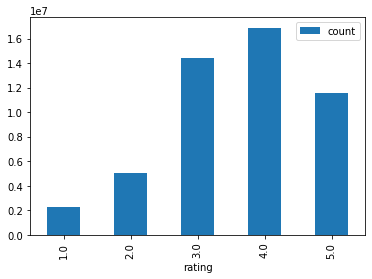

In [6]:
utils.rating_hist(df)

The bar plot above shows that most users rated movies between 3 and 4, while there were only a few ratings of 1 and 2. This implies that the users are generally happy with the movie selections that they can watch in Netflix.

**Table 5: Histogram of the Average Ratings***

<AxesSubplot:ylabel='Frequency'>

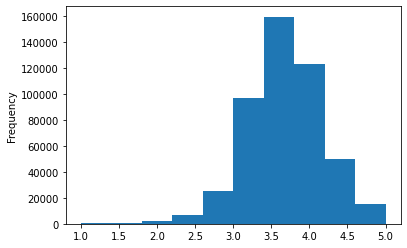

In [7]:
utils.avg_rating_hist(df)

We can also look at the histogram of the average ratings per user. It can be seen that average rating per user is still between 3.5 to 4, which implies that there might still be some room for improvement in the selections available in Netflix. The ratings between 4.5 and 5 are very small, and Netflix could focus on finding out what types of shows users want to be able to step up their offering.

**Table 6: No of Ratings per User**

In [8]:
# Group data by userId, count ratings
#userId_ratings = df.groupBy("userId").count().orderBy('count',
#                                                      ascending=False)
utils.userId_ratings(df)

+-------+-----+
| userId|count|
+-------+-----+
| 387418| 8783|
| 305344| 8717|
|2439493| 8268|
|1664010| 7874|
|2118461| 7437|
|1314869| 4912|
|1639792| 4870|
|1461435| 4858|
|2606799| 4505|
|1932594| 4438|
|2056022| 4207|
|1114324| 4195|
| 491531| 3716|
| 752642| 3707|
|1663888| 3511|
| 727242| 3441|
|1403217| 3414|
|1852040| 3370|
| 798296| 3364|
| 716173| 3363|
+-------+-----+
only showing top 20 rows



The table above shows the user ID and the number of ratings they have given over the period 1998 to 2005. User 387418 has rated the most number of movies, with 8,783 ratings. 

**Table 7: No of Ratings per User**

In [9]:
# Group data by movieId, count ratings
#movieId_ratings = df.groupBy("idx").count().orderBy('count', ascending=False)
utils.movieId_ratings(df)

+-----+------+
|  idx| count|
+-----+------+
| 5317|116707|
|15124|108485|
|14313|100526|
|15205| 98231|
| 1905| 97297|
| 6287| 96505|
|11283| 90882|
|16377| 90549|
|16242| 88827|
|12470| 88525|
|15582| 88182|
| 9340| 86782|
| 6972| 86151|
|12317| 82214|
| 2152| 81387|
|15107| 80134|
| 3860| 79900|
| 6037| 79341|
| 5496| 78224|
| 4432| 77872|
+-----+------+
only showing top 20 rows



Meanwhile, the number of ratings per movie is shown in the table above, where movie ID 5317 has the highest number of ratings at 1,167,707. 

## <span style="color: #E50914;">Matrix Sparsity </span>

However, it may be noted that one problem of collaborative filtering systems is data sparsity and the cold start problem. This is because users only watch a small percentage of the universe of movies, and they also do not rate all the movies that they watch. The cold start problem can also arise when there is a new Netflix subscriber or there is a new movie/series uploaded. 

The implication of matrix sparsity is that the standard form of matrix decomposition such as SVD cannot be used. 

In [10]:
utils.get_mat_sparsity(df)

The dfs dataframe is  99.41% sparse.


# <span style="background-color: #000000; color: #E50914"> Methodology </span>

The following diagram shows the methodology employed in this study.

**Figure 1: Methodology**

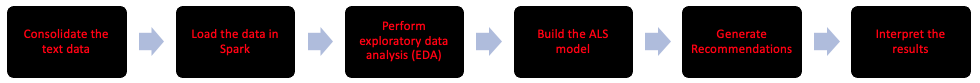

**Step 1: Consolidate the data**

The netflixprize dataset is contained in 17,770 files, with the first line in each text is the index. The text files were consolidated into one dataframe and cleaned to flatten the text file so that each row will contain the user ID, rating, date of the rating and the index. This was joined to the `movie_titles.txt` file to be able to interpret the results of the recommender system later on.

**Step 2: Load the Data in Spark**
The complete dataset was loaded as a Spark DataFrame, using the schema discussed in Table 1. Ony a fraction of the data was loaded due to limitations in computing power. Numerous trials have been run and it was found that we can run up to 50 million rows without OOM errors.
    
**Step 3: Perform Exploratory Data Analysis**
EDA was performed to understand the dataset. Descriptive statistics and histograms were generated to aid in this step.
    
**Step 4: Build the ALS Model**
The Spark MLlib model was used to build the ALS model. First, the data was split into a training set (80%) and a test set (20%). Next, the ALS model was built using the function calls of Spark's MLlib ALS. The model parameters were chosen after performing a grid search of the parameters of the model. The training set was then fit to the best model, and the RMSE was evaluated using the test set.

**Step 5: Generate Recommendations**
The recommendations for a specific user were generated using a function call in the ALS model. 

**Step 6: Interpret the Results**
It may be noted that the original dataset does not contain genre information. However, for the purpose of interpreting the results of a single user, we manually searched for the genre of the top movies that were recommended by the ALS model.

# <span style="background-color: #000000; color: #E50914"> ALS Model Building </span>

Spark MLlib has an implementation of collaborative filtering (CF). As mentioned, CF is commonly used in RS where the aim is to fill in the missing enries of a user-item association matrix. According to the documentation, spark.ml currently supports model-based CF, where users and the items are described by a small set of latent factors that can be used to predict the missing entries. The ALS algorithm described in the theoretical framework is the algorithm used to learn these factors.

## <span style="color: #E50914;"> Train-Test Split </span>

Similar to any machine learning problem, a train-test split was done to be able to train the model on historical data and test its performance against data that it has not seen before. This was done using the `randomSplit` call in the ALS library. 

In [5]:
# import libraries for ALS

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create test and train set
(train, test) = df.randomSplit([0.8, 0.2])

## <span style="color: #E50914;"> ALS Model </span>

The following parameters are needed for the model.

**Table 8: Parameters of the Model**

| Parameter         | Description                                                                                                |
|-------------------|------------------------------------------------------------------------------------------------------------|
| rank              | Number of latent factors in the model (defaults to 10)                                                     |
| maxIter           | Maximum number of iterations to run (defaults to 10)                                                        |
| regParam          | Regularization parameter in ALS (defaults to 1.0)                                                          |
| coldStartStrategy | if set to 'drop', the model assigns NaN predictions when a user or item factor is not present in the model |

The model parameters `rank`, `maxIter` and `regParam` are hyperparameters that can be tuned using gridsearch. 

It may be noted that in the paper by Zhou et al, they described the regularization parameter corresponding to the Tikhonov regularization. The regularization ensures that the ALS avoids overfitting. 

The columns corresponding to the user, item and rating also have to be specified in the model call. Moreover, the intermediate storage and final storage was set to `DISK_ONLY` because otherwise we will be faced with OOM errors, even after increasing the partition size (currently set at 21).

The following cell shows that an ALS model has been created.

In [28]:
# Create ALS model
als = ALS(rank=10, maxIter=5, regParam=0.1,
          userCol="userID", itemCol="idx", ratingCol="rating",
          coldStartStrategy="drop",
          checkpointInterval=10,
          intermediateStorageLevel='DISK_ONLY',
          finalStorageLevel='DISK_ONLY',
          seed=0)

# Confirm that a model called "als" was created
type(als)

pyspark.ml.recommendation.ALS

The ALS model was then fit on the training set.

In [29]:
# fit the ALS model on the train data
model = als.fit(train)

22/02/12 05:05:12 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/02/12 05:05:12 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


## <span style="color: #E50914;"> Model Evaluation </span>


The ALS model was used to generate the predictions by using the `transform` function call on the test set. A `RegressionEvaluator` object was made for the RMSE metric. The parameters in this object include the metric name (RMSE), the colum of the label (rating), and the column of the prediction (prediction).  The RMSE was computed using the funciton call `evaluate` on the evaluator object. The RMSE of the model is `0.8766`.

**Root Mean Squared Error (RMSE)**

It may be recalled that datasets for recommender systems have few items that contain most ratings, while most of the items have very few ratings. The nature of the dataset affects the accuracy measurements because the accuracy predictions will generally be different for the popular items compared to the sparsely-rated items. One solution to this problem is to give item-specific weights for each of the items when computing the RSME. Another practical consideration on why RMSE is used (compared to MAE) is that RMSE does not use absolute values. This makes it more convenient when calculating distances, gradients , or other metrics (Rackaitis, 2019).

In [9]:
## Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)

In [6]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [11]:
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8766357156568476


## <span style="color: #E50914;"> Model Tuning </span>

**Cross validation and hyperparameter tuning**

A grid search was performed using the `ParamGridBuilder`. The number of folds for cross validation was set at `5`. We did cross validation to further improve and tune the performance of our recommender model. Cross validation performs model selection by splitting the dataset into a set of non-overlapping randomly partitioned folds which are used as separate training and test datasets. In the setting the parameters of the cross validator, we considered testing `9 models`, consisting of 3 parameters for regParam, and 3 parameters for rank.

**NOTE ON THE ERRORS**: 

The OOM errors while performing cross validation could not be suppressed, hence you will see the errors and warning below. The final output of the cross validation is the `Cross Validator` object, which you can see was generated despite the errors and warnings.

In [11]:
#Cross-Validation
als_search = ALS(maxIter=5, numUserBlocks=16, numItemBlocks=16,
                 userCol="userID", itemCol="idx", ratingCol="rating",
                 coldStartStrategy="drop",
                 checkpointInterval=10,
                 nonnegative=True,
                 intermediateStorageLevel='DISK_ONLY',
                 finalStorageLevel='DISK_ONLY',
                 seed=0)

param_grid = (ParamGridBuilder()
             .addGrid(als_search.regParam, [0.01, 0.1, 0.5])
             .addGrid(als_search.rank, [10, 15, 20])
             .build())

print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  9


In [12]:
cv = CrossValidator(estimator=als_search,
                     estimatorParamMaps=param_grid,
                     evaluator=evaluator,
                     numFolds=5)
# Confirm cv was built
print(cv)

CrossValidator_4cf3989af947


In [13]:
model = cv.fit(train)

22/02/11 23:10:26 WARN CacheManager: Asked to cache already cached data.
22/02/11 23:10:26 WARN CacheManager: Asked to cache already cached data.
22/02/11 23:22:52 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/02/11 23:22:52 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/02/11 23:39:13 WARN MemoryStore: Not enough space to cache rdd_8_13 in memory! (computed 3.0 MiB so far)
22/02/11 23:39:14 WARN MemoryStore: Not enough space to cache rdd_8_14 in memory! (computed 5.8 MiB so far)
22/02/11 23:39:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_8_15 in memory.
22/02/11 23:39:14 WARN MemoryStore: Not enough space to cache rdd_8_15 in memory! (computed 384.0 B so far)
22/02/11 23:39:14 WARN MemoryStore: Not enough space to cache rdd_8_16 in memory! (computed 5.8 MiB so far)
22/02/11 23:39:14 WARN MemoryStore: Failed to reserve initial memory threshold

In [14]:
best_model = model.bestModel
best_model

ALSModel: uid=ALS_ddceae83b65e, rank=10

 After performing the grid search, the best parameters are `rank=10, maxIter=5, regParam=0.1`.

In [17]:
# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("The Best Model Parameters:")

# # Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())

# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
The Best Model Parameters:
  Rank: 10
  MaxIter: 5
  RegParam: 0.1


The RMSE of the best model using the test set was also evaluated. This yielded an RMSE of `0.8853`, which is notably higher than the initial ALS model.

In [22]:
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8853568823065113


**Table 9: Test Prediction of the Model**

The following table shows the output of the `transform` caall and how the predictions are shown. It can be see that a new column `prediction`, which contains the predicted rating of the user for each movie.

In [25]:
test_predictions = model.transform(test)
test_predictions.show()

+-------+------+-------------------+---+----------+
| userID|rating|          timestamp|idx|prediction|
+-------+------+-------------------+---+----------+
| 533250|   4.0|2001-05-09 00:00:00|148| 3.0083644|
| 729647|   4.0|2002-06-22 00:00:00|148| 4.5001454|
| 794227|   5.0|2005-04-17 00:00:00|148|  4.472221|
| 904455|   3.0|2004-05-08 00:00:00|148| 3.0276775|
| 946380|   3.0|2005-08-29 00:00:00|148| 2.5865126|
|1063244|   2.0|2001-09-01 00:00:00|148| 2.1432862|
|1297410|   3.0|2005-05-06 00:00:00|148| 3.3834243|
|1350612|   4.0|2004-07-12 00:00:00|148|  3.860117|
|1372156|   5.0|2004-05-03 00:00:00|148|  4.033782|
|1604716|   4.0|2003-09-21 00:00:00|148| 3.9934733|
|1698928|   3.0|2004-03-24 00:00:00|148| 3.0450478|
|1922435|   2.0|2005-07-07 00:00:00|148| 2.8748498|
|1931453|   5.0|2003-12-23 00:00:00|148|  4.125997|
|2376892|   4.0|2005-01-10 00:00:00|148| 3.4554923|
| 159154|   4.0|2005-12-17 00:00:00|148| 3.3026407|
| 285208|   3.0|2004-04-15 00:00:00|148| 2.9104688|
| 708596|   

# <span style="background-color: #000000; color: #E50914"> Results and Discussion </span>

Before we run the recommender system, we first consolidate the dataframe so that we can see the movie titles when the results are generated. The reason why this was not merged before fitting the model was because this information will not be used, and we wanted to ensure that we were dealing with a smaller dataset, which may affect the amount of memory that may be used in the operations (in the hopes that this will also avoid OOM errors).

**Table 10: Movie titles database**

In [23]:
movies = utils.load_titles()
movies.show()

+---+-------+--------------------+
|idx|movieID|               title|
+---+-------+--------------------+
|  1|   2003|     Dinosaur Planet|
|  2|   2004|Isle of Man TT 20...|
|  3|   1997|           Character|
|  4|   1994|Paula Abdul's Get...|
|  5|   2004|The Rise and Fall...|
|  6|   1997|                Sick|
|  7|   1992|               8 Man|
|  8|   2004|What the #$*! Do ...|
|  9|   1991|Class of Nuke 'Em...|
| 10|   2001|             Fighter|
| 11|   1999|Full Frame: Docum...|
| 12|   1947|My Favorite Brunette|
| 13|   2003|Lord of the Rings...|
| 14|   1982|  Nature: Antarctica|
| 15|   1988|Neil Diamond: Gre...|
| 16|   1996|           Screamers|
| 17|   2005|           7 Seconds|
| 18|   1994|    Immortal Beloved|
| 19|   2000|By Dawn's Early L...|
| 20|   1972|     Seeta Aur Geeta|
+---+-------+--------------------+
only showing top 20 rows



We can now generate the recommendations using the `recommendForAllUsers` function call. This allows us to specify how many users we want to generate ratings for. For computational efficiency, we only show the results for generating 10 recommendations for all users. The result is a spark dataframe that we would still need to explode so that we can inspect the recommendations in more detail. The results are saved in an array format with movie ID and movie ratings.

*Note: We used the initial ALS model since it has lower RMSE compared to best model returned by the cross validator.*

**Table 11: Recommended Movies (array format)**

In [30]:
nrecommendations = model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|   471|[{12398, 4.452623...|
|  1088|[{12398, 5.258126...|
|  2122|[{13556, 5.162117...|
|  2142|[{11500, 4.697746...|
|  2659|[{32, 4.6029305},...|
|  4101|[{5540, 4.609896}...|
|  6336|[{3456, 4.3028083...|
|  7554|[{1690, 4.9394655...|
|  8638|[{2934, 4.607221}...|
| 10817|[{14961, 4.591688...|
+------+--------------------+



The following dataframe shows the movies and ratings given by a sample user with `userID=471` from the first user in Table 11.

**Table 12: Actual Movies that the user likes**

In [31]:
actual_like = (df.join(movies, on='idx')
 .filter('userId = 471')
 .sort('rating', ascending=False)
 .toPandas())

In [32]:
actual_like

,idx,userID,rating,timestamp,movieID,title
0,4506,471,5.0,2002-07-24,1961,Breakfast at Tiffany's
1,14173,471,5.0,2004-08-03,1996,Ridicule
2,3623,471,5.0,2004-06-29,2002,Daughter from Danang: American Experience
3,17526,471,5.0,2004-01-21,1959,Some Like It Hot
4,4345,471,5.0,2004-06-29,2002,Bowling for Columbine
5,11451,471,5.0,2002-07-31,1999,The Iron Giant: Special Edition
6,7544,471,4.0,2003-09-30,2002,Orange County
7,1110,471,4.0,2004-09-28,2003,Secondhand Lions
8,5401,471,4.0,2005-07-07,2004,Dodgeball: A True Underdog Story
9,443,471,4.0,2004-10-27,2002,Rabbit-Proof Fence


**Table 13: Recommendations for userId 471**

The following table shows the recommendations sorted by the average predicted rating.

In [38]:
recos = (nrecommendations
            .withColumn("rec_exp", f.explode("recommendations"))
            .select('userId', f.col("rec_exp.idx"),
                    f.col("rec_exp.rating")))
recos_lim = recos.join(movies, on='idx').filter('userID=471').toPandas()
recos_lim

,idx,userId,rating,movieID,title
0,12398,471,4.452623,2004,Veronica Mars: Season 1
1,9039,471,4.421495,2004,The Boston Red Sox: 2004 World Series Collecto...
2,7815,471,4.370108,2003,Gilmore Girls: Season 4
3,1947,471,4.283976,2002,Gilmore Girls: Season 3
4,13478,471,4.279821,1973,Ivan Vasilievich: Back to the Future
5,7569,471,4.261811,2004,Dead Like Me: Season 2
6,12530,471,4.250602,2004,Sex and the City: Season 6: Part 2
7,16711,471,4.246684,2003,Sex and the City: Season 6: Part 1
8,7605,471,4.234303,2004,Queer as Folk: Season 4
9,7833,471,4.230238,2004,Arrested Development: Season 2


<i>Table 14</i> below shows the 20 watched and rated movies of `userId 471` with their respective genres. As we can observe, the movies watched and rated by `userId 471` are diverse based on genre. The user watches almost all kinds of movies and has no specification as to what movie genre they are into. Majority or nine (9) movie titles in this user's watch activity and ratings are in the comedy genre. Five (5) movie titles that this user watched or rated are from the action/adventure/fantasy genre.

**Table 14: Watched and Rated Movies of userId 471 with Genre**

|  idx 	|       title     	| genre                     	|
|:-----:	|:-------------------:	|-----------------------------------	|
| 14173 	| Ridicule            	| satire                            	|
| 10239 	| Seven Year Itch     	| comedy/ sex comedy                	|
| 7193  	| The Princess Bride  	| fantasy                           	|
| 4506  	| Breakfast at Tiff   	| drama/comedy drama                	|
| 4345  	| Bowling for Colum   	| Crime/ docufiction                	|
| 443   	| Rabbit-Proof Fence  	| Drama. Adventure/historical drama 	|
| 1110  	| Secondhand Lions    	| Historical film/ comedy drama     	|
| 7544  	| Orange County       	| Alternative/ indie                	|
| 5401  	| Dodgeball: A True   	| comedy/ sports                    	|
| 12577 	| Beany and Cecil     	| comedy/ animation                 	|
| 15078 	| Jumanji             	| Fantasy/ thriller                 	|
| 12828 	| Kinsey              	| drama                             	|
| 1179  	| The Education of    	| thriller/ drama/ mystery          	|
| 8317  	| Grosse Pointe Blank 	| thriller/ crime comedy            	|
| 2012  	| The Importance of   	| comedy/ farce                     	|
| 11532 	| The Charge of the   	| action/ history/ war/ adventure   	|
| 4141  	| Shanghai Noon       	| martial arts, action/ comedy      	|
| 14718 	| XXX: Special Editio 	| sexual/ mature                    	|
| 5020  	| Johnny English      	| acdventure/ comedty/ spy          	|
| 12084 	| Adaptation          	| comedy/ drama/ crime              	|

<i>Table 15</i> below shows the recommended movies for `userId 471` with its respective genre. These movies are the recommended movies for this user based on their previous watch activities and ratings. The model recommends mostly similar genres from the user's top rated movie genre, which is `comedy`. Different flavors of comedy were recommended, with crime, adventure, sex.

It can also be noted that specific series have been recommended. Usually viewers will not start watching a series with the second season or fourth season. Hence, the results of the recommender system can be further improved by recommending the first season (unless the previous seasons have already been watched). 

**Table 15: Recommended Movies for userId 471 with Genre**

| idx   	| title                 	| genre                                   	|
|-------	|-----------------------	|-----------------------------------------	|
| 6522  	| Trailer Park Boys     	| Comedy/Crime                            	|
| 7230  	| The Lord of the Rings 	| Action/Adventure/ Fantasy               	|
| 14961 	| The Lord of the Rings 	| Action/Adventure/ Fantasy               	|
| 7057  	| The Lord of the Rings 	| Action/Adventure/ Fantasy               	|
| 9864  	| Battlestar Galactica  	| Military/Science Fiction                	|
| 3456  	| Lost                  	| Mystery/Drama/Adventure/Science Fiction 	|
| 5258  	| Ken Burns' Civil War  	| History/War                             	|
| 12398 	| Veronica Mars         	| Mystery/Crime TV/Drama                  	|
| 7396  	| The Twilight Zone     	| Thriller/Suspense/Science Fiction       	|
| 3247  	| The Looney Tunes      	| Animation/Comedy                        	|

# <span style="background-color: #000000; color: #E50914"> Conclusion </span>

Recommender Systems are the lifeblood of streaming services such as Netflix, as this will keep customers coming back for more. For customers, getting good recommendations maximises their entertainment value and saves time and energy in searching for the next binge-watch worthy show. This study demonstrated how to use the Alternating Least Square (ALS) method as an alternative latent factor model in performing user-based and item-based recommender system.

This study demonstrated the use of Spark's MLlib as another tool to perform RS analysis using big data that cannot fit into memory. The model had an RMSE of `0.8766` compared to the Netflix prize in 2008's RMSE of `0.8995` (Zhou et al, 2008). The model was also able to generate recommendations for a single user. The recommended movies were similar to the top rated genre of a sample user.

The challenges encountered in this study include cleaning the data using Spark DataFrame, running the model efficiently (we encountered numerous OOM errors). Due to memory errors, we only used 50% of the data. Also, the cross validation step is not always replicable as there were times that we are getting higher RMSE than the original ALS configuration.

# <span style="background-color: #000000; color: #E50914"> Recommendation for Further Studies </span>

The following are the recommendation for further studies.

1. Use the complete dataset. The RMSE was only `0.8766` and this may improve if we are able to use more information.  The RMSE generated by the ALS model in this implementation is comparable to the original paper at 0.8895 (Zhou et al, 2008). The cross-validation of the model can also be improved by considering more parameters to really fine tune the model. Unfortunately, the computing resources available and the time constraint did now allow us to run more cross validation parameters. This study can be replicated using more computer power.

2. The methodology used collaborative filtering using alternating least squares. The ALS algorithm can be compared with the SVD algorithm and explore which model performs better (i.e., lower RMSE).

3. The use of the Surprise library can also be utilized and efficiency (run times), as well as performance, can be compared. 

4. Other evaluation metrics for recommender systems such as Mean Average Precision at K (MAP@K), Mean Average Recall @K (MAR@K), coverage, personalization and intra-list similarity can be explored.

# <span style="background-color: #000000; color: #E50914"> References </span>

Longo, C. (2018). Evaluation Metrics for Recommender Systems
(https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093#:~:text=Mean%20Average%20Precision%20at%20K,insights%20into%20a%20model's%20performance.)

Nair, S (2020). PySpark Collaborative Filtering with ALS
(https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679)

Siberling, A (2022). Netflix had its lowest year of subcriber growth since 2015. (https://techcrunch.com/2022/01/20/netflix-q4-2021-results-subscriber-numbers/#:~:text=Image%20Credits%3A%20Netflix&text=While%20Netflix%20has%20about%20222,at%20a%20more%20aggressive%20pace)

Spark Documention on Collaborative Filtering. (https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html)

Springboard India (2019). How Netflix’s Recommendation Engine Works.
(https://medium.com/@springboard_ind/how-netflixs-recommendation-engine-works-bd1ee381bf81#:~:text=For%20every%20new%20subscriber%2C%20Netflix,they%20would%20like%20to%20watch.&text=Netflix's%20machine%20learning%20based%20recommendations,the%20scenes%20and%20refreshes%20it.)

Rackaitis, T. (2019). Evaluating Recommender Systems: Root Means Squared Error or Mean Absolute Error? (https://towardsdatascience.com/evaluating-recommender-systems-root-means-squared-error-or-mean-absolute-error-1744abc2beac)

Zhou, Y. Wilkinson, D. Schreiber, R. and Pan, R. (2008). Large-Scale Parallel Collaborative Filtering for the Netflix Prize (https://link.springer.com/chapter/10.1007/978-3-540-68880-8_32)